<h1 align="center">Linear Discriminant Analysis</h1>

In [1]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


The goal of an LDA is to project a feature space (a dataset n-dimensional samples) onto a smaller subspace k (where k≤n−1) while maintaining the class-discriminatory information.

In general, dimensionality reduction does not only help reducing computational costs for a given classification task, but it
can also be helpful to avoid overfitting by minimizing the error in parameter estimation (“curse of dimensionality”).

Ronald A. Fisher formulated the Linear Discriminant in 1936 (The Use of Multiple Measurements in Taxonomic Problems), and it also has some practical uses as classifier. The original Linear discriminant was described for a 2-class problem, and it was then later generalized as “multi-class Linear Discriminant Analysis” or “Multiple Discriminant Analysis” by C. R. Rao in 1948 (The utilization of multiple measurements in problems of biological classification)

The general LDA approach is very similar to a Principal Component Analysis (for more information about the PCA, see the previous article Implementing a Principal Component Analysis (PCA) in Python step by step), but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA).

## Difference between LDA and PCA

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes.

 <img src="http://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png" />

In the rest of this notebook, we demonstrate the LDA method using Fisher's IRIS dataset.

In [2]:
import seaborn as sns

In [3]:
iris_df = sns.load_dataset('iris')

In [4]:
iris_df = iris_df.set_index('species')

In [5]:
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.1,3.5,1.4,0.2
setosa,4.9,3.0,1.4,0.2
setosa,4.7,3.2,1.3,0.2
setosa,4.6,3.1,1.5,0.2
setosa,5.0,3.6,1.4,0.2


## Normality assumptions

It should be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data.

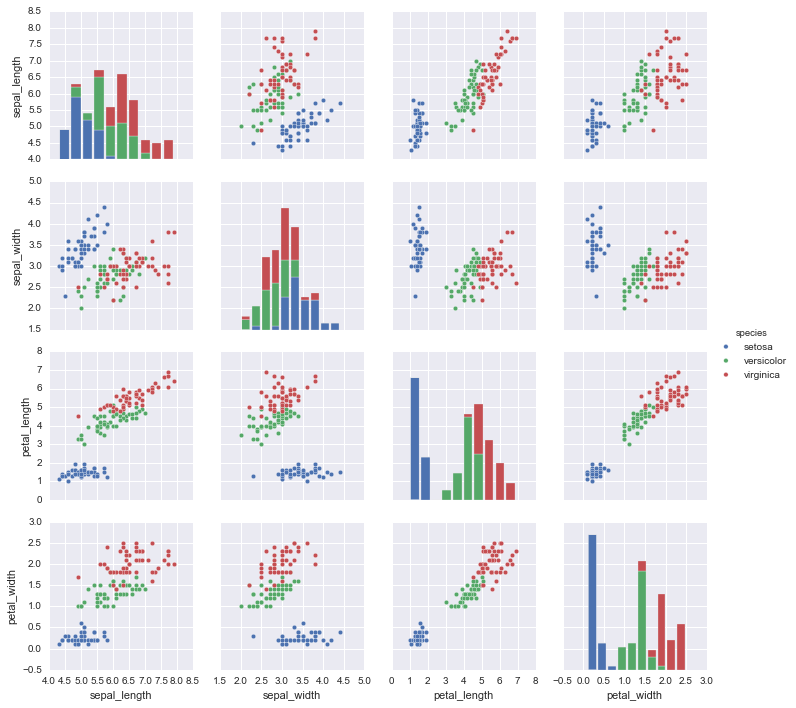

In [6]:
sns.pairplot(hue="species", data=iris_df.reset_index())

## LDA Step 1: Computing the d-dimensional mean vectors

In [7]:
label_means = iris_df.groupby(iris_df.index).mean()

In [8]:
label_means

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


## LDA Step 2: Within class Scatter Matrix

In [9]:
within_class_cov = iris_df.groupby(iris_df.index).cov()

In [10]:
within_class_cov

sepal_length  sepal_width  petal_length  petal_width
species                                                                      
setosa     sepal_length      0.124249     0.099216      0.016355     0.010331
           sepal_width       0.099216     0.143690      0.011698     0.009298
           petal_length      0.016355     0.011698      0.030159     0.006069
           petal_width       0.010331     0.009298      0.006069     0.011106
versicolor sepal_length      0.266433     0.085184      0.182898     0.055780
           sepal_width       0.085184     0.098469      0.082653     0.041204
           petal_length      0.182898     0.082653      0.220816     0.073102
           petal_width       0.055780     0.041204      0.073102     0.039106
virginica  sepal_length      0.404343     0.093763      0.303290     0.049094
           sepal_width       0.093763     0.104004      0.071380     0.047629
           petal_length      0.303290     0.071380      0.304588     0.048824
           petal_width       0.049094     0.047629      0.048824     0.075433

In [11]:
label_counts = iris_df.index.value_counts()

In [12]:
label_counts

virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64

The within class scatter matrix is defined by:

$S_{within} = \sum_{i}^c (N_i - 1) \times cov(D_i)$

Where 

* $c$ is the number of classes 
* $N_i$ is the number of samples in class $i$
* $cov(D_i)$ is the covariance matrix of the subset of samples in class $i$.

In [13]:
within_class_cov.loc['setosa'] * (label_counts['setosa'] - 1)

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,6.0882,4.8616,0.8014,0.5062
sepal_width,4.8616,7.0408,0.5732,0.4556
petal_length,0.8014,0.5732,1.4778,0.2974
petal_width,0.5062,0.4556,0.2974,0.5442


In [14]:
feature_names = within_class_cov.columns
reset_cov = within_class_cov.reset_index()

label_grouper = reset_cov.groupby(by='species')
s_within = label_grouper[feature_names].apply(lambda g: g * (label_counts[g.name]-1))

s_within.loc[:, 'level_1'] = reset_cov['level_1']

In [15]:
s_within = s_within.groupby(by='level_1').sum()
s_within.index.name = 'feature_name'

In [16]:
s_within

,sepal_length,sepal_width,petal_length,petal_width
feature_name,,,,
petal_length,24.6246,8.1208,27.2226,6.2718
petal_width,5.6450,4.8084,6.2718,6.1566
sepal_length,38.9562,13.6300,24.6246,5.6450
sepal_width,13.6300,16.9620,8.1208,4.8084


## LDA Step 3: Between class Scatter Matrix

In [17]:
overall_means = iris_df.mean()
overall_means.index.name = None

In [18]:
overall_means

sepal_length    5.843333
sepal_width     3.057333
petal_length    3.758000
petal_width     1.199333
dtype: float64

In [19]:
label_means

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


In [20]:
mean_diff = label_means.sub(overall_means, axis=1)

In [21]:
s_between = mean_diff.T.dot(mean_diff.mul(label_counts, axis=0))
s_between.columns = mean_diff.columns.copy()
s_between.index.name = 'feature_name'

In [22]:
s_between

,sepal_length,sepal_width,petal_length,petal_width
feature_name,,,,
sepal_length,63.212133,-19.952667,165.2484,71.279333
sepal_width,-19.952667,11.344933,-57.2396,-22.932667
petal_length,165.248400,-57.239600,437.1028,186.774000
petal_width,71.279333,-22.932667,186.7740,80.413333


## LDA Step 4: EigenValues and EigenVectors of $S_{within}^{-1} S_{between}$

In [23]:
s_within_inv = pd.DataFrame(data=np.linalg.inv(s_within), columns=s_within.columns, index=s_within.index)

In [24]:
s_dot = s_within_inv.dot(s_between)

In [25]:
eig_vals, eig_vecs = np.linalg.eig(s_dot)

eig_vals = pd.Series(eig_vals, index=feature_names)
eig_vecs = pd.DataFrame(eig_vecs, index=feature_names, columns=feature_names)

In [26]:
eig_vals

sepal_length   -1.010279e+01
sepal_width     3.407094e-01
petal_length    1.967844e-15
petal_width    -7.669689e-15
dtype: float64

In [27]:
eig_vecs

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.454953,0.793436,0.745904,-0.270434
sepal_width,0.279078,0.454150,-0.064125,0.409473
petal_length,-0.105142,-0.321864,-0.007123,0.469501
petal_width,-0.839094,0.246192,-0.662921,-0.734007
